# Fitting Anisotropic Power Diagrams to Grain Maps

In [1]:
# relevant libraries
import PyAPD
from pykeops.torch import LazyTensor
import copy
import torch
import matplotlib.pyplot as plt
import numpy as np

# typical setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
pwd()

'/home/mb/MEGAsync/academic_work/projects/geometric_model_polycrystals/code/PyAPD/notebooks/extensions/grain_maps_fitting'

In [3]:
file = "../../../data/2D_Tata_Steel_paper_example/sample_lc_steel_grain_file_final.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = PyAPD.load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt).contiguous()
A = A.to(device,dtype=dt).contiguous()
TV = TV.to(device,dtype=dt).contiguous()
N, D = X.shape

In [4]:
# Manually enter the correct domain size:
dom_x = [-999.02675,0.49975]
dom_y = [-901.0003,0.5003]
domain = torch.tensor([dom_x,dom_y])

# Compute total area and show largest and smallest grain:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(),
      "Smallest grain: ",torch.min(TV).cpu().numpy()
     )

Largest grain:  2073.79661128761 Smallest grain:  11.000898081641


In [5]:
# Construct an APD system:
apd1 = PyAPD.apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.1
                  )

In [6]:
W_heuristic = copy.deepcopy(apd1.W.contiguous())

In [7]:
apd1.check_optimality()

Precision loss detected!
Percentage error =  377.1113854263282


In [8]:
#apd1.find_optimal_W()

In [8]:
#apd1.check_optimality()
W_OT = copy.deepcopy(apd1.W.contiguous())

In [9]:
# Create a set of pixels to match the pixelated EBSD data:
i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 0.9995/2, apd1.domain[i,1] - 0.9995/2, 1000)

i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 1.0006/2, apd1.domain[i,1] - 1.0006/2, 901)

mesh1 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels1 = torch.stack(mesh1, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels1b = pixels1.reshape(-1, apd1.D)
pixels = pixels1b
PS = torch.ones(pixels.shape[0])

In [11]:
# Pass it to the apd system:
apd1.Y = pixels.to(device=apd1.device, dtype=apd1.dt).contiguous()
apd1.PS = PS.to(device=apd1.device, dtype=apd1.dt).contiguous()
apd1.y = LazyTensor(apd1.Y.view(1,apd1.Y.shape[0],apd1.D))

In [12]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_OT)
img_optimal = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_heuristic)
img_heuristic = copy.deepcopy(apd1.assemble_apd())

diff_opt_heu = sum(torch.abs(img_heuristic - img_optimal) > 0.5)

diff_opt_heu / img_optimal.shape[0]

tensor(0.)

In [13]:
# Load EBSD pixelated data: positions of pixels and grain assignment (from MTEX):
file = "../../../data/2D_Tata_Steel_paper_example/grainIDs_final.txt"
EBSD_pixel_data = torch.from_numpy(np.loadtxt(file)).to(device=apd1.device, dtype=apd1.dt)

In [14]:
Y = EBSD_pixel_data[:,0:2].contiguous()
Y_t = Y.view(1, len(Y), 2)
II = EBSD_pixel_data[:,2].int() # grain map
y = LazyTensor(Y_t)

In [15]:
# Save the data:
#W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

print("We have ", len(Y), " pixels and ", apd1.N, " grains.")

We have  896361  pixels and  4587  grains.


## Reduced approach: fitting $W$

#### Equipped with the grain map, as a warm up let us try to use the approach to recover $W$. For this we do not need to rescale the variables, so we just proceed as follows:

In [16]:
eps = 1e-2 # regularisation parameter
gtol_scalar = 1e-1

In [17]:
def objective_function(X,A,W, use_torch = False, return_grad = False):
    dims = A.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,II-1), torch.index_select(X, 0, II-1) - Y)
    sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,II-1)-Y) - torch.index_select(W, 0, II-1)
    first_sum = (-sD_ij/eps).sum()
    
    W_t = W.view(dims[0],1,1)
    X_t = X.view(dims[0], 1, dims[1])
    second_sum = None
    second_part_torch = None
    if use_torch:
        MV_s = torch.einsum('bij,bkj->bki',A,Y_t-X_t)
        D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t-X_t)
        D_ij_torch = D_ij_torch = (D_ij_torch[:,:,None] - W_t)[:,:,0]
        second_sum = (-D_ij_torch/eps).logsumexp(dim=0).sum(dim=0)
        second_part_torch = (-D_ij_torch/eps).softmax(dim=0).sum(dim=1)/eps
    else:
        a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
        w = LazyTensor(W_t)
        x = LazyTensor(X_t)
        D_ij = ((y - x) | a.matvecmult(y - x)) - w
        second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
    if return_grad:
        first_part = torch.bincount(II-1)/eps
        return -(first_sum - second_sum), -(first_part - second_part_torch)
    else:
        return -(first_sum - second_sum)

# Defining the convex function to be optmised:
fun_red = lambda W : objective_function(X_true,As_true, W)
fun_red_torch_grad = lambda W : objective_function(X_true,As_true, W, use_torch = True, return_grad = True)

In [18]:
W_OT_copy = copy.deepcopy(W_OT)
W_OT_copy.requires_grad = True
W_OT_copy

tensor([ 4.8877,  9.9497,  4.2786,  ..., 28.9199, 39.4976, 29.8692],
       requires_grad=True)

In [19]:
f1 = fun_red(W_OT_copy)
f1

tensor([4.0964e+08], grad_fn=<NegBackward0>)

In [21]:
d_f1 = torch.autograd.grad(f1, W_OT_copy, torch.ones_like(f1))[0]

[KeOps] Generating code for formula Sum_Reduction(-(-((Extract(Var(5,2,1),1,1)*Exp(-((Var(0,2,1)-Var(1,2,0))|MatVecMult(Var(2,4,0),Var(0,2,1)-Var(1,2,0))-Var(3,1,0))/Var(4,1,2)-Extract(Var(6,2,1),0,1)))/Var(4,1,2))),0) ... OK
[pyKeOps] Compiling pykeops cpp b9e73d4947 module ... OK


In [22]:
d_f1

tensor([ 500.,  800.,  200.,  ..., -600.,  100., -300.])

In [24]:
f2, d_f2 = fun_red_torch_grad(W_OT_copy)

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 65785726512 bytes. Error code 12 (Cannot allocate memory)

In [17]:
f2

tensor(3.5000)

In [18]:
d_f2

tensor([ 3539.5000,   595.7500,  -179.7500,  3884.7500, -5557.7500, -2421.2500,
        -3022.2500, -1286.7500,  4004.0000,   444.2500])

In [19]:
# check agreement between 
f12 = torch.abs(f1 - f2) # torch and keops for values
df12 = torch.abs(d_f1-d_f2).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.5000)


In [20]:
gtol = gtol_scalar*torch.ones(N).to(device=device) # optimality condition (can be passed as vector!)

# solver = 'bfgs'
# defaultKwargs = {'gtol': gtol,
#                  'xtol': -1e-10,
#                  'disp': 3,
#                  'max_iter':1000,
#                  'line_search': 'none',
#                  'lr': 1e-2,
#                 }

solver = 'newton-cg'
defaultKwargs = {#'gtol': gtol,
                 'xtol': 1e-6,
                 'disp': 3,
                 'max_iter':1000,
                 #'line_search': 'none',
                 #'lr': 1e-2,
                }

res = PyAPD.minimize_torch(fun_red, torch.zeros(N), method=solver,
                             options=defaultKwargs)

W_approx = res.x

initial fval: 7487.0000
iter   1 - fval: 1161.5625
iter   2 - fval: 172.8750
iter   3 - fval: 25.8750
iter   4 - fval: 4.0625
iter   5 - fval: 3.2500
iter   6 - fval: 2.5000
iter   7 - fval: 2.2500
iter   8 - fval: 2.1250
iter   9 - fval: 2.1250
Optimization terminated successfully.
         Current function value: 2.125000
         Iterations: 9
         Function evaluations: 26
         CG iterations: 23


In [21]:
res.grad

tensor([  18.7500,   17.5000,  185.0000,   38.0000, -246.0000,   14.7500,
         -86.0000,   45.7500,  -70.7500,   82.0000])

In [22]:
W_approx.requires_grad = True

In [23]:
print(fun_red(W_approx))
print(fun_red(W_true_copy))

tensor([2.1250], grad_fn=<NegBackward0>)
tensor([3.5000], grad_fn=<NegBackward0>)


In [24]:
f1_approx = fun_red(W_approx)
f1_approx

tensor([2.1250], grad_fn=<NegBackward0>)

In [25]:
d_f1_approx = torch.autograd.grad(f1_approx, W_approx, torch.ones_like(f1_approx))[0]

In [26]:
d_f1_approx

tensor([  18.7500,   17.5000,  185.0000,   38.0000, -246.0000,   14.7500,
         -86.0000,   45.7500,  -70.7500,   82.0000])

In [27]:
f2_approx, d_f2_approx = fun_red_torch_grad(W_approx)

In [28]:
f2_approx

tensor(2.1250, grad_fn=<NegBackward0>)

In [29]:
d_f2_approx

tensor([  19.0000,   17.5000,  185.2500,   38.2500, -245.7500,   15.0000,
         -86.0000,   45.7500,  -70.7500,   82.7500], grad_fn=<NegBackward0>)

In [30]:
# check agreement between 
f12 = torch.abs(f1_approx - f2_approx) # torch and keops for values
df12 = torch.abs(d_f1_approx-d_f2_approx).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.7500, grad_fn=<MaxBackward1>)


Number of misassigned pixels:  tensor(0)
Proportion of misassigned pixels:  tensor(0.)


Text(0.5, 1.0, 'Misalligned pixels')

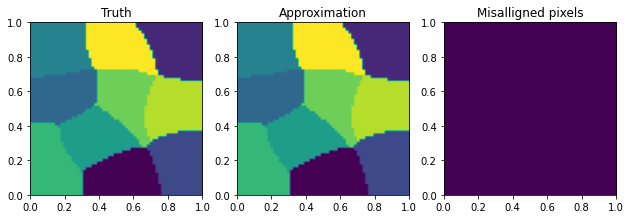

In [31]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_approx)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

apd1.set_W(W = W_true) # reset weights to the optimum

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### All seems to work pretty well!

## Full approach: Fitting $X$, $\Lambda$ and $W$ at the same time

#### First let us try a naive approach where we do not worry too much about the matrices $\mathbf{A}_i$ being positive definite, but only with them being symmetric. That way each matrix only gives three variables $a_{i,11}$, $a_{i,22}$ and $a_{i,12}$. We thus have a flat variable
$$
\theta = \{(x_{i,1}, x_{i,2}, a_{i,11}, a_{i,22}, a_{i,12}, w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$
#### and e.g. we can assemble the optimum that we know:

In [32]:
theta_true = torch.cat((X_true[:,0],X_true[:,1],As_true[:,0,0],As_true[:,1,1],As_true[:,0,1],W_true))
theta_true

tensor([ 5.3611e-01,  8.4343e-01,  8.6315e-01,  1.8746e-01,  1.6148e-01,
         3.7004e-01,  1.2661e-01,  5.6004e-01,  8.3718e-01,  5.1368e-01,
         1.1579e-01,  8.5074e-01,  1.8788e-01,  5.7136e-01,  8.4644e-01,
         3.3537e-01,  1.8131e-01,  5.4257e-01,  5.1628e-01,  8.5078e-01,
         8.0797e-01,  1.2595e+00,  1.3996e+00,  9.0563e-01,  1.0015e+00,
         7.1593e-01,  1.7043e+00,  1.2384e+00,  6.8453e-01,  6.4579e-01,
         1.2846e+00,  1.0525e+00,  7.1593e-01,  1.1260e+00,  9.9855e-01,
         1.4419e+00,  5.9276e-01,  8.3160e-01,  1.5650e+00,  1.6853e+00,
         1.9480e-01,  5.7063e-01,  4.4706e-02, -1.4045e-01, -1.9916e-03,
        -1.7970e-01,  1.0115e-01,  1.7282e-01, -2.6697e-01,  2.9721e-01,
        -3.9132e-03,  1.7624e-03, -1.0214e-02, -2.3867e-03,  1.6388e-03,
         7.5559e-03,  1.3046e-03,  1.7452e-03,  6.8301e-03, -4.2494e-03])

#### We can also introduce the rescaled variables 
$$
\tilde \theta = \{(\tilde x_{i,1}, \tilde x_{i,2}, \tilde a_{i,11}, \tilde a_{i,22}, \tilde a_{i,12}, \tilde w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$

In [33]:
def rescaling(X, As, W):
    At = As/eps
    Xt = 2.0*torch.einsum('bij,bj->bi', As, X)/eps
    Wt = (W - torch.einsum('bj,bj->b',X,eps*Xt/2.0))/eps
    return Xt, At, Wt

def inverse_rescaling(Xt, At, Wt):
    As = eps*At
    X = (eps/2.0)*torch.linalg.solve(As,Xt)
    MV = torch.einsum('bij,bj->bi', As, X)
    W = eps*Wt + torch.einsum('bj,bj->b',MV,X)
    return X, As, W

In [34]:
Xt_true, At_true, Wt_true = rescaling(X_true, As_true, W_true)
thetat_true = torch.cat((Xt_true[:,0],Xt_true[:,1],At_true[:,0,0],At_true[:,1,1],At_true[:,0,1],Wt_true))

#### And the new rescaled objective is

In [35]:
def objective_function_tilde(Xt,At,Wt, use_torch = False, return_grad = False):
    dims = At.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(At,0,II-1), Y)
    sD_ij = torch.einsum('bj,bj->b',MV,Y) - torch.index_select(Wt, 0, II-1) - torch.einsum('bi,bi->b',torch.index_select(Xt, 0, II-1),Y)
    first_sum = (-sD_ij).sum()

    Wt_t = Wt.view(dims[0],1,1)
    Xt_t = Xt.view(dims[0], 1, dims[1])
    second_sum = None
    #second_part_torch = None
    if use_torch:
        MV_s = torch.einsum('bij,bkj->bki',At,Y_t)
        D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t)
        D_ij_torch = ((D_ij_torch[:,:,None] - Wt_t) - torch.einsum('ijk,lik->lji',Y_t,Xt_t))[:,:,0]
        second_sum = (-D_ij_torch).logsumexp(dim=0).sum(dim=0)
    else:
        at = LazyTensor(At.view(dims[0], 1, dims[1] * dims[2]))
        wt = LazyTensor(Wt_t)
        xt = LazyTensor(Xt_t)
        D_ij =  (y | at.matvecmult(y)) - wt - ((y*xt).sum(dim=2))
        second_sum = (-D_ij).logsumexp(dim=0).sum(dim=0)
    return -(first_sum - second_sum)

#### We also want have the ability to go from flat variables to shaped variables quickly, so here are some helper functions:

In [36]:
def As_from_scalars(a11,a22,a12):
    return torch.stack([torch.stack([a11, a12],dim=1),
                            torch.stack([a12, a22], dim=1)],dim=2)

def X_from_scalar(x1,x2):
    return torch.stack([x1,x2],dim=1)

def from_theta_to_X_A_W(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    a11 = theta[(2*N):(3*N)]
    a22 = theta[(3*N):(4*N)]
    a12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_scalars(a11,a22,a12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [37]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W(thetat_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W(theta_true)
print(torch.dist(As_test,As_true))

tensor(8.9755e-08)
tensor(9.6642e-08)


In [38]:
# Defining the convex function to be optmised:
def fun(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [39]:
# Defining the convex function to be optmised:
def fun_torch(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt, use_torch=True)

In [40]:
# Sanity check
print(fun(thetat_true),fun_red(W_true))

tensor([3.4375]) tensor([3.5000])


In [41]:
thetat_true.requires_grad = True

In [42]:
f1 = fun(thetat_true)
f1

tensor([3.4375], grad_fn=<NegBackward0>)

In [43]:
d_f1 = torch.autograd.grad(f1, thetat_true, torch.ones_like(f1))[0]

In [44]:
d_f1

tensor([ 0.1099,  0.0386, -0.0149,  0.1190, -0.1808, -0.0459, -0.1182, -0.1001,
         0.2914, -0.0980,  0.0461,  0.0564, -0.0064,  0.2287, -0.4233, -0.1860,
         0.0402, -0.0788,  0.2745,  0.0490, -0.0345, -0.0237,  0.0136, -0.0378,
         0.0603,  0.0081,  0.0383,  0.0770, -0.2117,  0.1112, -0.0062, -0.0526,
         0.0024, -0.1400,  0.3234,  0.0994, -0.0424,  0.0470, -0.1855, -0.0452,
        -0.0291, -0.0720,  0.0112, -0.1387,  0.2770,  0.0823,  0.0078,  0.1245,
        -0.3972,  0.1343,  0.3540,  0.0596, -0.0180,  0.3884, -0.5559, -0.2422,
        -0.3022, -0.1290,  0.4001,  0.0453])

In [45]:
f2 = fun_torch(thetat_true)
f2

tensor(3.3750, grad_fn=<NegBackward0>)

In [46]:
d_f2 = torch.autograd.grad(f2, thetat_true, torch.ones_like(f2))[0]

In [47]:
d_f2

tensor([ 0.1099,  0.0384, -0.0148,  0.1191, -0.1807, -0.0459, -0.1182, -0.1004,
         0.2917, -0.0980,  0.0461,  0.0562, -0.0064,  0.2287, -0.4229, -0.1860,
         0.0402, -0.0791,  0.2748,  0.0488, -0.0345, -0.0237,  0.0136, -0.0378,
         0.0602,  0.0081,  0.0383,  0.0772, -0.2120,  0.1112, -0.0062, -0.0524,
         0.0024, -0.1400,  0.3230,  0.0994, -0.0424,  0.0472, -0.1857, -0.0451,
        -0.0291, -0.0717,  0.0112, -0.1387,  0.2768,  0.0823,  0.0078,  0.1250,
        -0.3978,  0.1343,  0.3540,  0.0593, -0.0180,  0.3884, -0.5554, -0.2422,
        -0.3022, -0.1296,  0.4006,  0.0450])

In [48]:
# check agreement between 
f12 = torch.abs(f1 - f2) # torch and keops for values
df12 = torch.abs(d_f1-d_f2).max() # autodiff torch vs keops
print(f12, df12)

tensor([0.0625], grad_fn=<AbsBackward0>) tensor(0.0006)


In [49]:
gtol = gtol_scalar*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-1.0))*torch.ones(N),((eps)**(-1.0))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

#thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
#                            torch.ones(N),torch.ones(N), torch.zeros(N),
#                            torch.zeros(N)))

fun(thetat_initial)

tensor([17926482.])

In [51]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0.0, 'disp': 2, 'max_iter':10000}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':1000,
                 'line_search': 'none',
                 'lr': 1e-1,
                }

# solver = 'newton-cg'
# defaultKwargs = {#'gtol': gtol,
#                  #'xtol': -1e-10,
#                  'disp': 3,
#                  'max_iter':500,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

# solver='cg'
# defaultKwargs = {'gtol': 1e-3,
#                  #'xtol': 1e-10,
#                  'disp': 3,
#                  'max_iter':1000,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

res = PyAPD.minimize_torch(fun_torch, thetat_initial, method=solver,
                             options=defaultKwargs)

thetat_approx = res.x

Optimality condition successfully overwritten.
initial fval: 17926482.0000
iter   1 - fval: 17926424.0000
iter   2 - fval: 19430002.0000
iter   3 - fval: 18648808.0000
iter   4 - fval: 12985087.0000
iter   5 - fval: 11571696.0000
iter   6 - fval: 7549067.0000
iter   7 - fval: 7081850.0000
iter   8 - fval: 6775671.0000
iter   9 - fval: 6110950.0000
iter  10 - fval: 5783942.0000
iter  11 - fval: 5550201.0000
iter  12 - fval: 4991879.0000
iter  13 - fval: 4221981.0000
iter  14 - fval: 4032731.0000
iter  15 - fval: 3852591.0000
iter  16 - fval: 3697816.0000
iter  17 - fval: 3505627.0000
iter  18 - fval: 3287656.0000
iter  19 - fval: 3147597.0000
iter  20 - fval: 3007640.0000
iter  21 - fval: 2816696.0000
iter  22 - fval: 2610199.0000
iter  23 - fval: 2286114.0000
iter  24 - fval: 1843865.0000
iter  25 - fval: 1573833.0000
iter  26 - fval: 1436005.0000
iter  27 - fval: 1188240.0000
iter  28 - fval: 1101997.0000
iter  29 - fval: 1016137.0000
iter  30 - fval: 920664.0000
iter  31 - fval: 8364

In [52]:
res.grad

tensor([-1.0608e-01, -1.8433e-01, -4.2999e-02,  5.5551e-01,  3.2543e-02,
        -4.9133e-01, -3.8391e-02,  3.6520e-01, -8.8074e-02, -3.9673e-04,
         8.0990e-02, -2.6239e-01, -1.9547e-02,  9.1518e-01,  9.4360e-02,
        -8.9600e-01,  1.9295e-02,  1.3713e-01, -3.2730e-02, -3.5370e-02,
         6.9878e-02,  1.0822e-01,  1.3434e-01, -1.8871e-01,  3.4237e-04,
         1.4135e-01,  7.5483e-03, -2.8892e-01,  3.3417e-02, -1.7143e-02,
         6.6776e-03,  2.2958e-01,  1.2400e-02, -4.7662e-01, -2.0081e-02,
         4.3660e-01, -7.5621e-02, -8.2695e-02,  3.7697e-02, -6.8146e-02,
        -2.4555e-02,  4.1632e-01,  1.2445e-01, -5.7594e-01, -5.7518e-02,
         5.0024e-01,  4.7156e-02, -3.5242e-01,  6.8756e-02, -1.4731e-01,
        -3.5889e-02, -2.5549e-01,  1.2024e-01,  1.8148e+00,  1.3116e-01,
        -1.7835e+00, -5.6427e-02,  4.3231e-01, -1.9540e-01, -1.7047e-01])

In [53]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [54]:
thetat_approx.requires_grad = True

In [55]:
print(fun(thetat_approx))
print(fun(thetat_true))

tensor([286.], grad_fn=<NegBackward0>)
tensor([3.4375], grad_fn=<NegBackward0>)


In [56]:
f1_approx = fun(thetat_approx)
f1_approx

tensor([286.], grad_fn=<NegBackward0>)

In [57]:
d_f1_approx = torch.autograd.grad(f1_approx, thetat_approx, torch.ones_like(f1_approx))[0]

In [58]:
d_f1_approx

tensor([-1.0599e-01, -1.8396e-01, -4.3152e-02,  5.5568e-01,  3.2391e-02,
        -4.9144e-01, -3.8467e-02,  3.6511e-01, -8.7769e-02, -1.5564e-03,
         8.1059e-02, -2.6178e-01, -1.9600e-02,  9.1556e-01,  9.4116e-02,
        -8.9618e-01,  1.9173e-02,  1.3693e-01, -3.2425e-02, -3.6591e-02,
         6.9832e-02,  1.0812e-01,  1.3440e-01, -1.8877e-01,  3.9959e-04,
         1.4136e-01,  7.5645e-03, -2.8889e-01,  3.3112e-02, -1.6350e-02,
         6.6648e-03,  2.2900e-01,  1.2415e-02, -4.7694e-01, -1.9897e-02,
         4.3666e-01, -7.5569e-02, -8.2550e-02,  3.7506e-02, -6.7230e-02,
        -2.4609e-02,  4.1559e-01,  1.2453e-01, -5.7621e-01, -5.7281e-02,
         5.0029e-01,  4.7194e-02, -3.5223e-01,  6.8268e-02, -1.4560e-01,
        -3.5614e-02, -2.5488e-01,  1.2009e-01,  1.8153e+00,  1.3095e-01,
        -1.7840e+00, -5.6824e-02,  4.3210e-01, -1.9507e-01, -1.7203e-01])

In [59]:
f2_approx = fun_torch(thetat_approx)
f2_approx

tensor(286., grad_fn=<NegBackward0>)

In [60]:
d_f2_approx = torch.autograd.grad(f2_approx, thetat_approx, torch.ones_like(f2_approx))[0]

In [61]:
d_f2_approx

tensor([-1.0608e-01, -1.8433e-01, -4.2999e-02,  5.5551e-01,  3.2543e-02,
        -4.9133e-01, -3.8391e-02,  3.6520e-01, -8.8074e-02, -3.9673e-04,
         8.0990e-02, -2.6239e-01, -1.9547e-02,  9.1518e-01,  9.4360e-02,
        -8.9600e-01,  1.9295e-02,  1.3713e-01, -3.2730e-02, -3.5370e-02,
         6.9878e-02,  1.0822e-01,  1.3434e-01, -1.8871e-01,  3.4237e-04,
         1.4135e-01,  7.5483e-03, -2.8892e-01,  3.3417e-02, -1.7143e-02,
         6.6776e-03,  2.2958e-01,  1.2400e-02, -4.7662e-01, -2.0081e-02,
         4.3660e-01, -7.5621e-02, -8.2695e-02,  3.7697e-02, -6.8146e-02,
        -2.4555e-02,  4.1632e-01,  1.2445e-01, -5.7594e-01, -5.7518e-02,
         5.0024e-01,  4.7156e-02, -3.5242e-01,  6.8756e-02, -1.4731e-01,
        -3.5889e-02, -2.5549e-01,  1.2024e-01,  1.8148e+00,  1.3116e-01,
        -1.7835e+00, -5.6427e-02,  4.3231e-01, -1.9540e-01, -1.7047e-01])

In [62]:
# check agreement between 
f12 = torch.abs(f1_approx - f2_approx) # torch and keops for values
df12 = torch.abs(d_f1_approx-d_f2_approx).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.0017)


In [63]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(), As = As_approx.contiguous(), W = W_approx2.contiguous())

Number of misassigned pixels:  tensor(39)
Proportion of misassigned pixels:  tensor(0.0101)


Text(0.5, 1.0, 'Misalligned pixels')

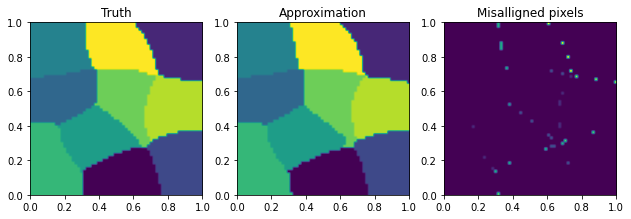

In [64]:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

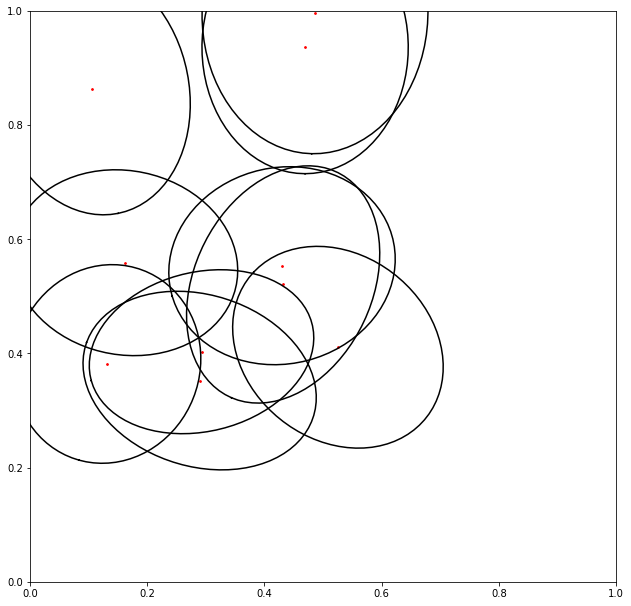

In [65]:
apd2.plot_ellipses()

In [66]:
torch.linalg.det(apd2.As)

tensor([1.0829, 0.4478, 1.0432, 1.0361, 0.7526, 1.3763, 1.3132, 0.9244, 0.9053,
        0.6658])

#### Not caring about positive definiteness of the matrices seems to affect things, which can be seen e.g. by restarting the optimisation procedure at a better initial guess:

In [67]:
print("The found optimum: ", fun(res.x))
print("The known actually optimum: ", fun(thetat_true))

The found optimum:  tensor([286.], grad_fn=<NegBackward0>)
The known actually optimum:  tensor([3.4375], grad_fn=<NegBackward0>)


In [68]:
res2 = PyAPD.minimize_torch(fun, thetat_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 3.4375
iter   1 - fval: 3.4375
iter   2 - fval: 3.2500
iter   3 - fval: 3.1250
iter   4 - fval: 3.0000
iter   5 - fval: 2.8750
iter   6 - fval: 2.6250
iter   7 - fval: 2.5625
iter   8 - fval: 2.5000
iter   9 - fval: 2.3750
iter  10 - fval: 2.2500
iter  11 - fval: 2.0625
iter  12 - fval: 2.1250
iter  13 - fval: 2.0625
iter  14 - fval: 1.9375
iter  15 - fval: 1.9375
iter  16 - fval: 1.8125
iter  17 - fval: 1.8125
iter  18 - fval: 1.6875
iter  19 - fval: 1.6875
iter  20 - fval: 1.6875
iter  21 - fval: 1.5625
iter  22 - fval: 1.5625
iter  23 - fval: 1.5000
iter  24 - fval: 1.5625
iter  25 - fval: 1.4375
iter  26 - fval: 1.3750
iter  27 - fval: 1.3750
iter  28 - fval: 1.3125
iter  29 - fval: 1.2500
iter  30 - fval: 1.1875
iter  31 - fval: 1.2500
iter  32 - fval: 1.1875
iter  33 - fval: 1.2500
iter  34 - fval: 1.0625
iter  35 - fval: 1.0625
iter  36 - fval: 1.0000
iter  37 - fval: 1.0000
iter  38 - fval: 1.0000
iter  39 - fval: 0.8

In [69]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [70]:
torch.linalg.det(As_approx)

tensor([1.0829, 0.4478, 1.0432, 1.0361, 0.7526, 1.3763, 1.3132, 0.9244, 0.9053,
        0.6658], grad_fn=<LinalgDetBackward0>)

In [71]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(), As = As_approx.contiguous(), W = W_approx2.contiguous())

Number of misassigned pixels:  tensor(39)
Proportion of misassigned pixels:  tensor(0.0101)


Text(0.5, 1.0, 'Misalligned pixels')

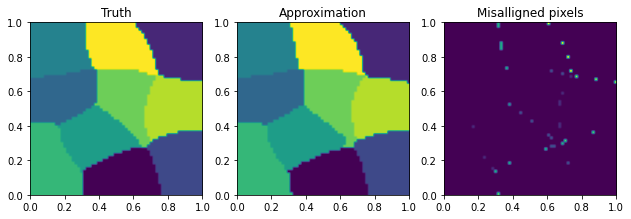

In [72]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')